### Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
from sklearn.model_selection import train_test_split
from collections import defaultdict

import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [4]:
data = pd.read_excel("отзывы за лето.xls")

stop_words = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = txt.lower()
    txt = re.sub('https?://\S+|www\.\S+', ' ', txt)
    txt = re.sub(r'\)+', ' веселый', txt)
    txt = re.sub(r'\(+', ' грустный', txt)
    txt = re.sub(r'[^\w\s]',' ', txt)
    txt = re.sub(r'[0-9]+', ' ', txt)
    txt = re.sub('\n', ' ', txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in stop_words]
    txt = " ".join(txt)
    txt = re.sub("не\s", "не", txt)
    return txt


data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3
data['target'] = data['target'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=42, stratify=data['target'])

In [5]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, padding='post')
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, padding='post')

In [6]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.padded_batch(BATCH_SIZE)

In [7]:
VOCAB_SIZE = len(word_index)+1
EMBEDDING_DIM = 128
WEIGHT_DECAY = 0.01
wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

### RNN

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         905984    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 947,201
Trainable params: 947,201
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time
num_epochs = 5
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])


history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset)

Epoch 1/5
124/124 [==============================] - 35s 285ms/step - loss: 0.4872 - auc: 0.4986 - val_loss: 0.4283 - val_auc: 0.5017
Epoch 2/5
124/124 [==============================] - 34s 277ms/step - loss: 0.4288 - auc: 0.5597 - val_loss: 0.3734 - val_auc: 0.7630
Epoch 3/5
124/124 [==============================] - 36s 294ms/step - loss: 0.3760 - auc: 0.7505 - val_loss: 0.3508 - val_auc: 0.7633
Epoch 4/5
124/124 [==============================] - 36s 288ms/step - loss: 0.3664 - auc: 0.7573 - val_loss: 0.3508 - val_auc: 0.7640
Epoch 5/5
124/124 [==============================] - 36s 290ms/step - loss: 0.3633 - auc: 0.7573 - val_loss: 0.3467 - val_auc: 0.7678
Wall time: 3min 2s


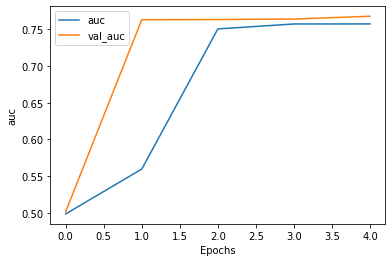

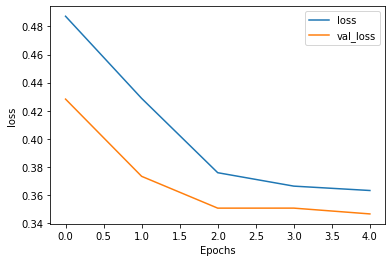

In [10]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc")  
plot_graphs(history, "loss")

### LSTM

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         905984    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,050,241
Trainable params: 1,050,241
Non-trainable params: 0
____________________________________________

In [12]:
%%time
num_epochs = 5
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])


history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset)

Epoch 1/5
124/124 [==============================] - 13s 108ms/step - loss: 0.4944 - auc_1: 0.5733 - val_loss: 0.3571 - val_auc_1: 0.8765
Epoch 2/5
124/124 [==============================] - 11s 85ms/step - loss: 0.3216 - auc_1: 0.8411 - val_loss: 0.2695 - val_auc_1: 0.9099
Epoch 3/5
124/124 [==============================] - 10s 85ms/step - loss: 0.2319 - auc_1: 0.9270 - val_loss: 0.1958 - val_auc_1: 0.9534
Epoch 4/5
124/124 [==============================] - 11s 88ms/step - loss: 0.1696 - auc_1: 0.9594 - val_loss: 0.1860 - val_auc_1: 0.9569
Epoch 5/5
124/124 [==============================] - 10s 85ms/step - loss: 0.1450 - auc_1: 0.9689 - val_loss: 0.1883 - val_auc_1: 0.9537
Wall time: 1min 9s


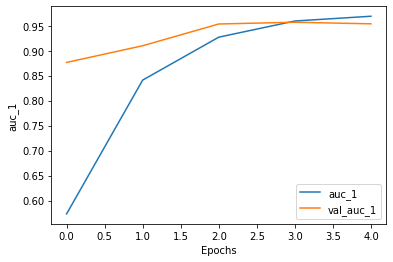

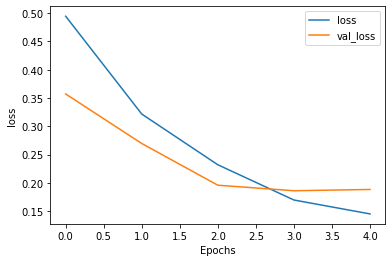

In [13]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc_1")  
plot_graphs(history, "loss")

### GRU

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         905984    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                31104     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 937,485
Trainable params: 937,485
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%time
num_epochs = 5
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])


history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset)

Epoch 1/5
124/124 [==============================] - 8s 66ms/step - loss: 0.6221 - auc_2: 0.5842 - val_loss: 0.5266 - val_auc_2: 0.9142
Epoch 2/5
124/124 [==============================] - 7s 55ms/step - loss: 0.4070 - auc_2: 0.7327 - val_loss: 0.3438 - val_auc_2: 0.9095
Epoch 3/5
124/124 [==============================] - 7s 55ms/step - loss: 0.3160 - auc_2: 0.9230 - val_loss: 0.2940 - val_auc_2: 0.9241
Epoch 4/5
124/124 [==============================] - 7s 55ms/step - loss: 0.2658 - auc_2: 0.9386 - val_loss: 0.2577 - val_auc_2: 0.9354
Epoch 5/5
124/124 [==============================] - 7s 57ms/step - loss: 0.2359 - auc_2: 0.9495 - val_loss: 0.2400 - val_auc_2: 0.9419
Wall time: 42.4 s


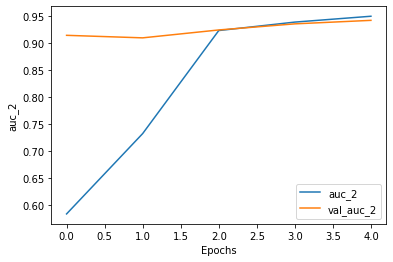

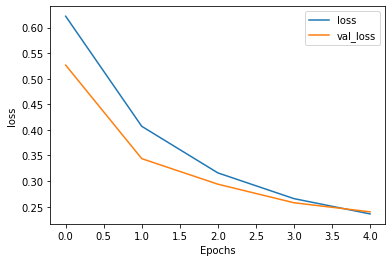

In [16]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "auc_2")  
plot_graphs(history, "loss")